# TensorFlow Decision Forests를 이용한 Spaceship Titanic 데이터셋

이 노트북은 이번 경진대회에서 제공된 Spaceship Titanic 데이터셋에 TensorFlow Decision Forests를 사용하여 베이스라인 Random Forest 모델을 훈련하는 과정을 안내합니다.

대략적인 코드는 다음과 같습니다:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests는 Random Forests와 Gradient Boosted Trees를 포함하는 트리 기반 모델 제품군입니다. 정형 데이터(tabular data)를 다룰 때 시작하기 가장 좋은 모델이며, 신경망(neural networks) 실험을 시작하기 전에 종종 더 나은 성능을 보이거나 강력한 베이스라인을 제공합니다.

# 라이브러리 임포트

In [1]:
# import tensorflow as tf
# import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

NameError: name 'tf' is not defined

# 데이터셋 로드

In [3]:
# Pandas 데이터프레임으로 데이터셋 로드
dataset_df = pd.read_csv('C:/Users/User/Desktop/Github/sklearn-est15th-realfinal/Spaceship_Titanic/train.csv')
print("전체 훈련 데이터셋의 크기는 {}입니다.".format(dataset_df.shape))

전체 훈련 데이터셋의 크기는 (8693, 14)입니다.


데이터는 14개의 열과 8693개의 항목으로 구성되어 있습니다. 다음 코드를 사용하여 처음 5개 항목을 출력함으로써 데이터셋의 모든 14개 차원을 확인할 수 있습니다:

In [4]:
# 처음 5개 예제 표시
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


12개의 특성(feature) 열이 있습니다. 이러한 특성을 사용하여 모델은 `Transported` 열에 표시된 승객의 구조 여부를 예측해야 합니다.

# 데이터셋의 기본적인 탐색을 빠르게 수행해 보겠습니다.

In [5]:
dataset_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# 레이블 열(Transported)에 대한 막대 그래프



<Axes: xlabel='Transported'>

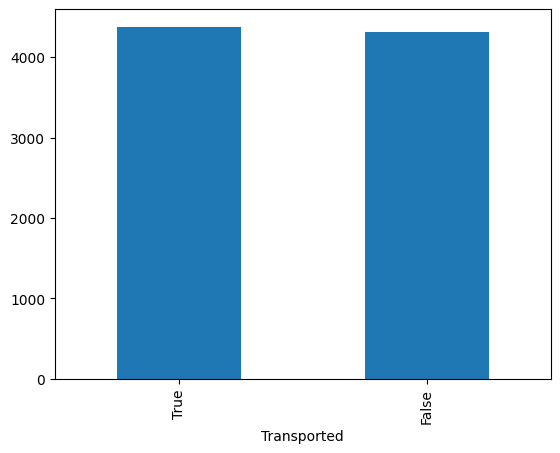

In [4]:
plot_df = dataset_df.Transported.value_counts()
plot_df.plot(kind="bar")

# 수치형 데이터 분포

모든 수치형 열과 해당 값의 빈도(value counts)를 그래프로 그려보겠습니다:

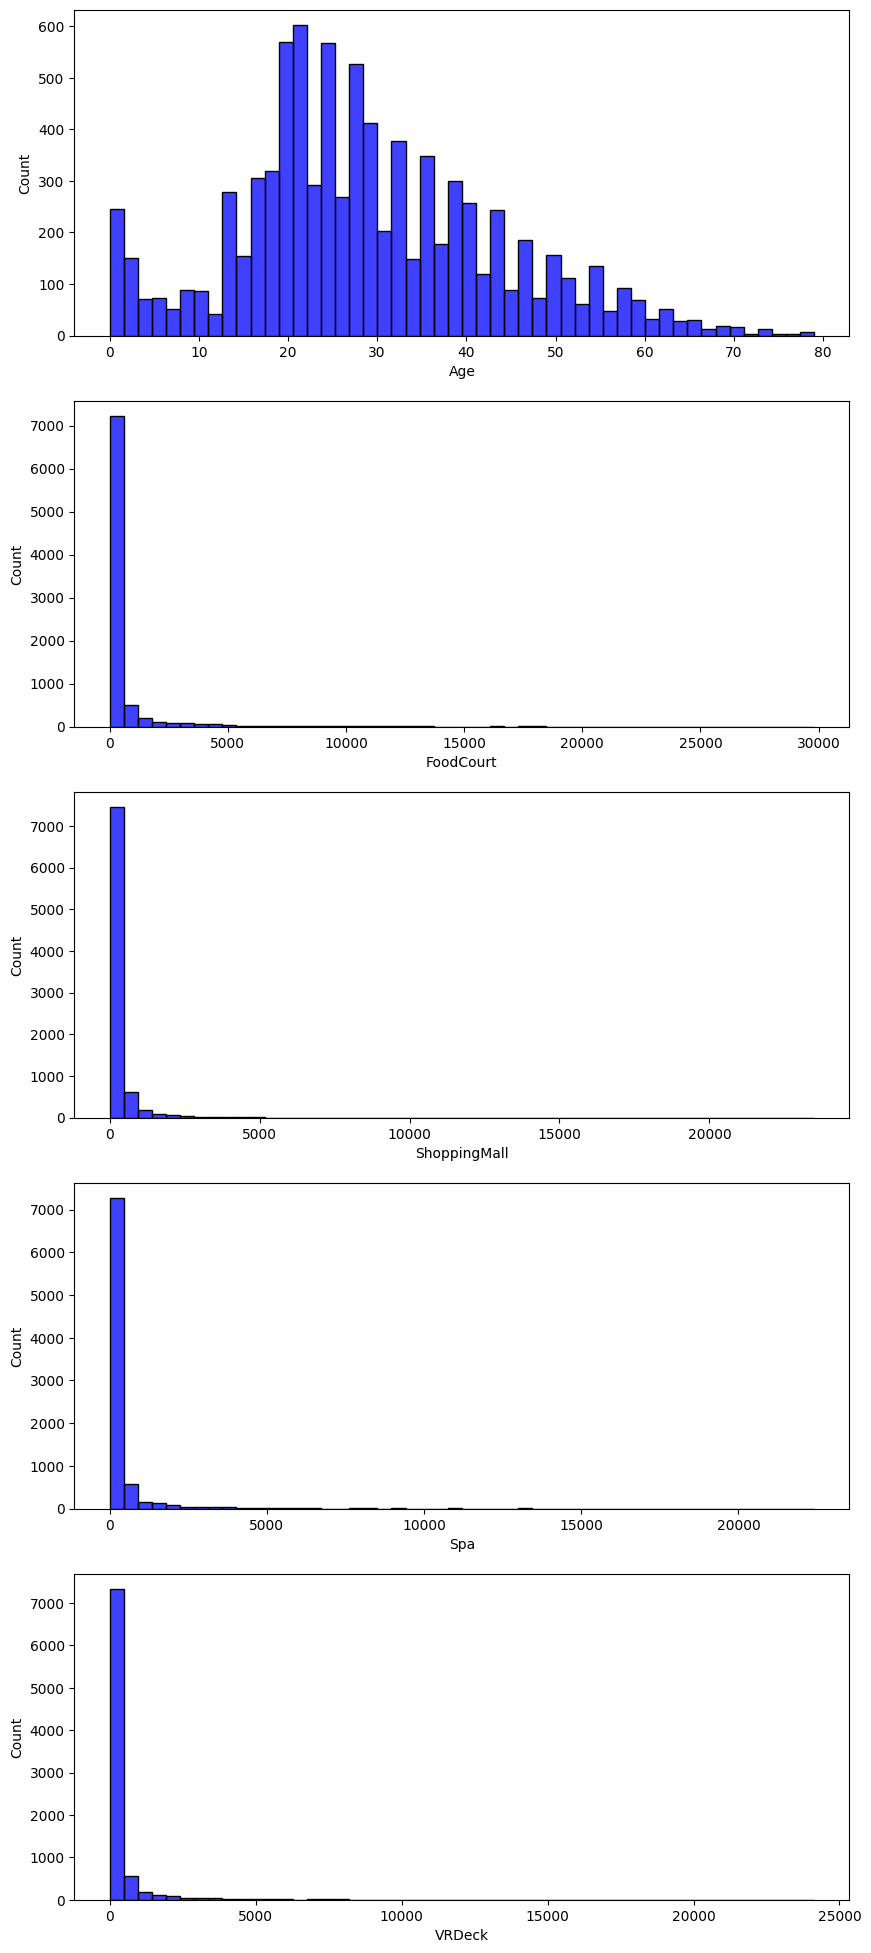

In [5]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(dataset_df['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(dataset_df['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(dataset_df['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(dataset_df['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(dataset_df['VRDeck'], color='b', bins=50, ax=ax[4]);

# 데이터셋 준비

모델 훈련에 필요하지 않은 `PassengerId`와 `Name` 열은 삭제하겠습니다.

In [ ]:
dataset_df = dataset_df.drop(['PassengerId', 'Name'], axis=1)
dataset_df.head(5)

다음 코드를 사용하여 결측치를 확인하겠습니다:

In [ ]:
dataset_df.isnull().sum().sort_values(ascending=False)

이 데이터셋은 수치형, 범주형 및 결측치 특성이 혼합되어 있습니다. TF-DF는 이러한 모든 특성 유형을 기본적으로 지원하므로 별도의 전처리지 필요하지 않습니다.

하지만 이 데이터셋에는 결측치가 포함된 불리언(boolean) 필드도 있습니다. TF-DF는 아직 불리언 필드를 지원하지 않으므로 이러한 필드를 정수(int)로 변환해야 합니다. 불리언 필드의 결측치를 처리하기 위해 0으로 대체하겠습니다.

이 노트북에서는 수치형 열의 결측치도 0으로 대체하고, 범주형 열의 결측치만 TF-DF가 처리하도록 하겠습니다.

참고: 필요에 따라 TF-DF가 수치형 열의 결측치를 처리하도록 선택할 수도 있습니다.

In [ ]:
dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
dataset_df.isnull().sum().sort_values(ascending=False)

TF-DF는 불리언 열을 처리할 수 없으므로, `Transported` 열의 레이블을 TF-DF가 기대하는 정수 형식으로 변환해야 합니다.

In [ ]:
label = "Transported"
dataset_df[label] = dataset_df[label].astype(int)

또한 `CryoSleep` 및 `VIP` 불리언 필드를 정수형으로 변환하겠습니다.

In [ ]:
dataset_df['VIP'] = dataset_df['VIP'].astype(int)
dataset_df['CryoSleep'] = dataset_df['CryoSleep'].astype(int)

`Cabin` 열의 값은 `Deck/Cabin_num/Side` 형식의 문자열입니다. 여기서는 `Cabin` 열을 분할하여 `Deck`, `Cabin_num`, `Side`라는 3개의 새로운 열을 생성하겠습니다. 이렇게 개별 데이터로 모델을 훈련하는 것이 더 쉽기 때문입니다.

다음 명령을 실행하여 `Cabin` 열을 `Deck`, `Cabin_num`, `Side` 열로 분할합니다.

In [ ]:
dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)

더 이상 필요하지 않은 원본 `Cabin` 열을 데이터셋에서 제거합니다.

In [ ]:
try:
    dataset_df = dataset_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

준비된 데이터셋에서 처음 5개 예제를 표시해 보겠습니다.

In [ ]:
dataset_df.head(5)

이제 데이터셋을 훈련 및 테스트 데이터셋으로 분할하겠습니다:

In [ ]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

모델을 훈련하기 전에 한 가지 단계가 더 필요합니다. 데이터셋을 Pandas 형식(`pd.DataFrame`)에서 TensorFlow Datasets 형식(`tf.data.Dataset`)으로 변환해야 합니다.

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview)는 GPU 및 TPU와 같은 가속기를 사용하여 신경망을 훈련할 때 도움이 되는 고성능 데이터 로딩 라이브러리입니다.

In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)

# 모델 선택

선택할 수 있는 몇 가지 트리 기반 모델이 있습니다.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

우선 Random Forest로 시작해 보겠습니다. 이는 Decision Forest 훈련 알고리즘 중 가장 잘 알려진 모델입니다.

Random Forest는 결정 트리(decision trees)의 집합체로, 각 트리는 훈련 데이터셋의 무작위 하위 집합(중복 허용 샘플링)에서 독립적으로 훈련됩니다. 이 알고리즘은 과적합(overfitting)에 강하고 사용하기 쉽다는 특징이 있습니다.

다음 코드를 사용하여 TensorFlow Decision Forests에서 제공하는 모든 가용 모델을 나열할 수 있습니다:

In [ ]:
tfdf.keras.get_all_models()

# 모델 설정

TensorFlow Decision Forests는 좋은 기본값(예: 벤치마크에서 상위권을 기록한 하이퍼파라미터를 합리적인 시간 내에 실행되도록 약간 수정한 값)을 제공합니다. 학습 알고리즘을 직접 설정하고 싶다면, 가능한 최고의 정확도를 얻기 위해 탐색할 수 있는 다양한 옵션이 있습니다.

다음과 같이 템플릿을 선택하거나 파라미터를 설정할 수 있습니다:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")```

자세한 내용은 [여기](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel)에서 확인하세요.

# Random Forest 생성

오늘은 기본값을 사용하여 Random Forest 모델을 생성하겠습니다. 기본적으로 모델은 분류(classification) 작업을 수행하도록 설정되어 있습니다.

In [ ]:
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=["accuracy"]) # Optional, you can use this to include a list of eval metrics

# 모델 훈련

한 줄의 코드로 모델을 훈련하겠습니다.

참고: Autograph와 관련된 경고가 나타날 수 있습니다. 이는 다음 릴리스에서 수정될 예정이므로 안심하고 무시하셔도 됩니다.

In [ ]:
rf.fit(x=train_ds)

# 모델 시각화
트리 기반 모델의 장점 중 하나는 쉽게 시각화할 수 있다는 것입니다. Random Forest에서 사용되는 기본 트리 개수는 300개입니다. 아래에서 표시할 트리를 선택할 수 있습니다.

In [ ]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

# OOB(Out of bag) 데이터 및 검증 데이터셋으로 모델 평가

데이터셋을 훈련하기 전에 검증을 위해 데이터셋의 20%를 `valid_ds`라는 이름으로 수동 분리했습니다.

RandomForestModel을 검증하기 위해 OOB(Out of bag) 점수를 사용할 수도 있습니다.
Random Forest 모델을 훈련할 때, 알고리즘은 훈련 세트에서 무작위 샘플 세트를 선택하고 나머지 샘플은 모델을 미세 조정하는 데 사용됩니다. 선택되지 않은 데이터 하위 집합을 OOB(Out of bag) 데이터라고 합니다.
OOB 점수는 이 OOB 데이터에서 계산됩니다.

OOB 데이터에 대한 자세한 내용은 [여기](https://developers.google.com/machine-learning/decision-forests/out-of-bag)에서 읽어보세요.

훈련 로그는 모델의 트리 개수에 따른 OOB 데이터셋의 평가 정확도를 보여줍니다. 이를 그래프로 그려보겠습니다.

참고: 이 하이퍼파라미터는 값이 클수록 좋습니다.

In [ ]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

OOB 데이터셋에 대한 몇 가지 일반적인 통계도 확인할 수 있습니다:

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

이제 검증 데이터셋을 사용하여 평가를 진행해 보겠습니다.

In [ ]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

# 변수 중요도(Variable importances)

변수 중요도는 일반적으로 특정 특성이 모델의 예측이나 품질에 얼마나 기여하는지를 나타냅니다. TensorFlow Decision Forests를 사용하여 중요한 특성을 식별하는 여러 방법이 있습니다.
Decision Trees에서 사용 가능한 변수 중요도 목록을 확인해 보겠습니다:

In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

예를 들어, 변수 중요도 `NUM_AS_ROOT`에 대한 중요한 특성들을 표시해 보겠습니다.

`NUM_AS_ROOT`의 중요도 점수가 클수록 모델의 결과에 더 큰 영향을 미칩니다.

기본적으로 목록은 가장 중요한 것부터 가장 덜 중요한 순으로 정렬됩니다. 출력 결과로부터 목록의 상단에 있는 특성이 Random Forest의 다른 어떤 특성보다 많은 수의 트리에서 루트 노드(root node)로 사용되었음을 알 수 있습니다.

In [ ]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

# 제출

In [ ]:
# 테스트 데이터셋 로드/ test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df.PassengerId

# NaN 값을 0으로 대체
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Cabin 열에서 Deck, Cabin_num, Side라는 새로운 특성 생성 및 Cabin 열 삭제
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df = test_df.drop('Cabin', axis=1)

# 불리언(boolean) 값을 1과 0으로 변환
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# Pandas 데이터프레임을 TensorFlow 데이터셋으로 변환
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# 테스트 데이터에 대한 예측 얻기
predictions = rf.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

In [ ]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()